# Mushroom Classification

Attempting to create a sequential neural network trained on the [Mushroom Classification dataset from Kaggle](https://www.kaggle.com/uciml/mushroom-classification) to see if we can determine a mushroom's odor based on its other factors.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from sklearn import preprocessing, model_selection
from keras.models import Sequential, load_model 
from keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

In [2]:
# import data
data = pd.read_csv('/content/drive/MyDrive/ML/GBC/DL1/week2/mushrooms.csv')

X = data
X = X.drop('odor', axis=1)
Y = data[['odor']]

In [3]:
data[['odor']].value_counts()

odor
n       3528
f       2160
y        576
s        576
l        400
a        400
p        256
c        192
m         36
dtype: int64

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

In [5]:
def label_encode_features(df):
  ret = df

  for col_name in ret:
    label_encoder = LabelEncoder()
    label_encoder.fit(ret[col_name])
    ret[col_name] = label_encoder.transform(ret[col_name])

  return ret

X_encoded = label_encode_features(X)

In [6]:
Y_encoder = LabelEncoder()
Y_encoder.fit(Y)
Y_encoder_name_mapping = dict(zip(Y_encoder.classes_, Y_encoder.transform(Y_encoder.classes_)))

Y_encoded = Y_encoder.transform(Y)
class_order = Y_encoded
Y_encoded = np_utils.to_categorical(Y_encoded)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [7]:
# split data
train_x, test_x, train_y, test_y = model_selection.train_test_split(
  X_encoded,
  Y_encoded,
  test_size = 0.2,
  random_state = 42
)

In [8]:
# %% NN architecture
input_dim = train_x.shape[1]

model = Sequential()
model.add(Dense(8, input_dim = input_dim , activation = 'relu'))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(9, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'] )

In [9]:
# %% NN training
model.summary() # model architecture
checkpointer = ModelCheckpoint(filepath="weights.hdf5", monitor = 'val_accuracy', verbose=1, save_best_only=True) # save model's best weights

history = model.fit(
  train_x, 
  train_y, 
  epochs=30, 
  batch_size=2, 
  callbacks = [checkpointer], 
  validation_data = (test_x, test_y)
)

model_name = "mushrooms.h5"
model.save(model_name)
model = load_model(model_name)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 184       
                                                                 
 dense_1 (Dense)             (None, 10)                90        
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 10)                110       
                                                                 
 dense_4 (Dense)             (None, 9)                 99        
                                                                 
Total params: 593
Trainable params: 593
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
3242/3250 [============================>.] - ET


History Keys:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


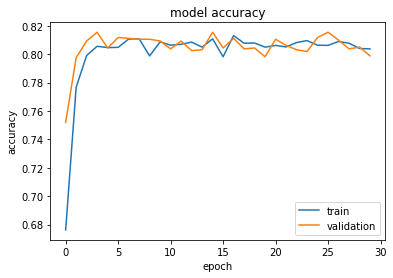

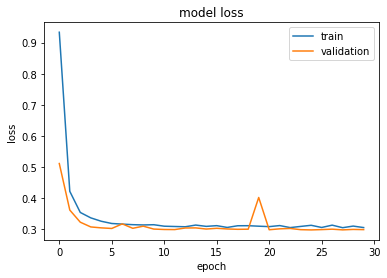

In [10]:
# %% Predictions

y_pred = model.predict(test_x)
y_pred = np.argmax(y_pred, axis = 1)
y_pred = Y_encoder.inverse_transform(y_pred)

Y = np.argmax(Y, axis = 1) 
Y = Y_encoder.inverse_transform(Y)

test_y = np.argmax(test_y, axis = 1) 
test_y = Y_encoder.inverse_transform(test_y)

print("\nHistory Keys:\n")
print(history.history.keys())

plt.subplots() # open a new plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

plt.subplots() # open a new plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

odors:
- almond=a
- anise=l
- creosote=c
- fishy=y
- foul=f
- musty=m
- none=n
- pungent=p
- spicy=s

In [11]:
cm = confusion_matrix(y_pred, test_y)
cm

array([[ 36,   0,   0,  55,   0,   0,   0,   0,   0],
       [  0,  37,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 430,   0,   0,   0,   0, 105, 123],
       [ 44,   0,   0,  38,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   5,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 695,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,  57,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0]])

## Visualizing the confusion matrix

Remembering the counts of classes from before:

- n (none) = 3528
- f (foul) = 2160
- y (fishy) = 576
- s (spicy) = 576
- l (anise) = 400
- a (almond) = 400
- p (pungent) = 256
- c (creosote) = 192
- m (musty) = 36

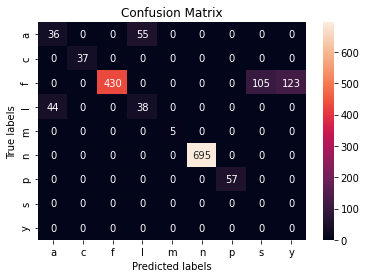

In [12]:
import seaborn as sns

ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(Y_encoder_name_mapping); ax.yaxis.set_ticklabels(Y_encoder_name_mapping);